# Data Collection and Description

Import libraries needed in this notebook:

In [2]:
import pandas as pd
import gzip
from tqdm import tqdm

from datetime import datetime
from datetime import date, time
from dateutil.parser import parse
import numpy as np
import pandas as pd


from bokeh.plotting import figure, output_notebook, show
from bokeh.models import DatetimeTickFormatter

import json
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# Metadata :
Before taking a closer look at the ratings we will consider the metadata dataset. In this dataset we will amongst other things find information about title, price, description, and the products each product is related to. In order to examine the metadata, we load part of it into a data frame to be able to see it and do some descriptive statistics.

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in tqdm(parse(path)):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')
# GET THE DATA 

meta = getDF('reviews_Electronics_5.json.gz')
meta.head()

1689188it [02:10, 12906.46it/s]


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [ ]:
pickling_on = open("Electronics.pickle","wb")
pickle.dump(meta, pickling_on)
pickling_on.close()

In [5]:
pickle_off = open("Electronics.pickle","rb")
df = pickle.load(pickle_off)

We see that we have nine columns in total:

- asin (This is the id of the product)
- brand
- categories (list of different categories, that the product belongs to)
- description (can be very long, e.g. a book summary)
- imUrl (URL to picture of the product)
- price
- related (dictionary of different features concerning related products. In particular: also_bpught, also_viewed, boght_together)
- salesRank (ranking of product within their category based on how much it sells)
- title

Most of these things are observable from the dataset, but some things needed a seperate explaination such as the salesRank, which we found on Amazon.com.

In order to manually see if something is off with the data, e.g. unexpected or missing values, we export the first 2000 records to an html table and take a look at that file. Here is shown the first five records. 

In [ ]:
meta.info()

**Observations form the inspection of the HTML table:**

In the html table we see that there are many missing values also within the important attributes such as price and salesRank. This is going to cause some issue in the further analysis and there for the strategy for the handling of this is important. We want to later examine the correlations between price and ratings and rating and SalesRank. In that sense it might be interesting to see which categories have the least missing values in order to select those categories for these kinds of analysis. 

Another thing that is noticed, is that apart from having missing values the Brand column also contains values called ‘Unknown’. This indicate that a seller at Amazon can mark the brand as ‘Unknown’ as well as just not putting any value. As long a we keep this in mind it should not be a problem later.

*Some of these observations has been made on different subsets of the meta data*


# Reviews:

## Downloading the data :

The review data is divided in several json files according to the Amazon category of the corresponding products (books, videos, … ). For now, we are going to focus on the Amazon_instant_video category - which is small enough to run on our computers- before extending our analysis to the others. WE note that we use the 5-core dataset which means that teh original dataset has been reduced so that each of the remaining users and items have 5 reviews each.

We start by downloading the file. Then we store it into a pandas dataframe which will enable us to have a clear overview of the data.


#### Understanding the data:

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in tqdm(parse(path)):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')
# GET THE DATA 

df = getDF('reviews_Electronics_5.json.gz')
df.head()

1689188it [01:40, 16812.34it/s]


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


Both the reviewr and the product are identified by codes, respectively `reviewerID`and `asin`.We also have the actual name of the reviewer.
The text of the reviews as well as the corresponding summaries are represented by strings.
Each review is characterized by: 
- the name and the id of the reviewer
- the identification of the product
- a text and a summary 
- an overall rating score
- a list of two items giving thethe number of people that found the review usefuland the total number of people who read it.
- the review time , given both in unix format and as a string.

Our first step is to change the type of review time to datetime format.


In [6]:
#the dates are initially strings --> convert them to datetime format 
df.reviewTime=pd.to_datetime(df.reviewTime)

In [4]:
#which are the variables that contain Nan values : 
print(df.shape)
df.isnull().any()

(1689188, 9)


reviewerID        False
asin              False
reviewerName       True
helpful           False
reviewText        False
overall           False
summary           False
unixReviewTime    False
reviewTime        False
dtype: bool

We notice that some of the reviewer names are missing but since the reviewer Id are available anyway, this is not an issue.

## Variables
enrich the dataframe with new variables 

In [ ]:
#other values than the number of review for each date :number of reviewers (up to that year)? length of reviews ? length of summary ?
#takes a very long time (too long -> think of something else to do this)
df['year']=list(map(lambda x:x.year,df.reviewTime))
df['length_review']=list(map(lambda x:len(x.split(' ')),df.reviewText))
#df['length_title_reviews']=list(map(lambda x:len(x),df.summary))
df['number of reviewers']=list(map(lambda x:len(set(df[df.year==x].reviewerID)),df.year))

In [13]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,year,length_review
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,2013-06-02,2013,156
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,2010-11-25,2010,446
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,2010-09-09,2010,888
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,2010-11-24,2010,449
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,2011-09-29,2011,202
5,A2JXAZZI9PHK9Z,0594451647,"Billy G. Noland ""Bill Noland""","[3, 3]",I am using this with a Nook HD+. It works as d...,5.0,HDMI Nook adapter cable,1388707200,2014-01-03,2014,22
6,A2P5U7BDKKT7FW,0594451647,Christian,"[0, 0]",The cable is very wobbly and sometimes disconn...,2.0,Cheap proprietary scam,1398556800,2014-04-27,2014,22
7,AAZ084UMH8VZ2,0594451647,"D. L. Brown ""A Knower Of Good Things""","[0, 0]",This adaptor is real easy to setup and use rig...,5.0,A Perfdect Nook HD+ hook up,1399161600,2014-05-04,2014,120
8,AEZ3CR6BKIROJ,0594451647,Mark Dietter,"[0, 0]",This adapter easily connects my Nook HD 7&#34;...,4.0,A nice easy to use accessory.,1405036800,2014-07-11,2014,88
9,A3BY5KCNQZXV5U,0594451647,Matenai,"[3, 3]",This product really works great but I found th...,5.0,This works great but read the details...,1390176000,2014-01-20,2014,185


In [ ]:
#pd.merge(df,meta,how='inner',on='asin')

In [14]:
pickling_on = open("Electronics.pickle","wb")
pickle.dump(df, pickling_on)
pickling_on.close()

## Prepare the functions 

## plot the data in time

In this section, we will define a few functions that will help us visualize our data in time.
We first plot the daily number of reviews through the years.

In [23]:
# through the whole timeline 
evolution = df.groupby('reviewTime').count()

# output to static HTML file
#output_file("Videos_evolution.html", title="Evolution of the number of reviews through the years")
output_notebook()
# create a new plot with a a datetime axis type
p = figure(width=1000, height=500, x_axis_type="datetime")

# add renderers
avg=evolution.asin.rolling(182,center=True).mean() # moving average to have something smoother
p.line(evolution.index.values,evolution.asin, color='navy')
p.line(evolution.index.values,avg, color='red')
# NEW: customize by setting attributes
p.title.text = "Daily Number of Reviews"
p.legend.location = "top_left"
p.grid.grid_line_alpha=0
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Number of reviews'
p.xaxis[0].formatter = DatetimeTickFormatter(days='%m/%d',years='%Y',months='%B')
# show the results
show(p)

Loading BokehJS ...

We notice that although the data goes from 2000 to 2014, there are very few reviews until 2012. The amazon Instant video service was actually created September the 7th, 2006.It seems that the data before that date is wrong.

In [24]:
df[df.year<2006]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,year,length_review,length_title_reviews
541,A20EEWWSFMZ1PN,B000MN4YR0,"bernie ""xyzzy""","[0, 0]",The answer to the riddle is in the tittle. Onc...,5.0,They Do It with Mirrors,975456000,2000-11-29,2000,387,23
3114,A3LZGLA88K0LA0,B001SRN6IW,Michael Butts,"[2, 3]",Without the star presenced of Julia Roberts an...,4.0,ERIN BROCKOVICH MEETS JOHN Q,1098403200,2004-10-22,2004,1333,28


### dividing the data by year 


We will now divide the dataset into year intervals. 
For this purpose, we create a dataframe where the columns represent a year and each row represent a day from January 1st to December 31st : We will initialize the dataframe with 336 rows so that the bisextile years are taken into account.

In [25]:
#define a function that will count the number of reviews for a given year
def yearly_count (Y,Count):
    data = df[df.year==Y].groupby('reviewTime').count()
    frequency=data[['asin']].copy()
    frequency.columns=['year'+str(Y)]
    frequency['dates']=list(map(lambda x:x.strftime('%m-%d'), frequency.index))
    Count=pd.merge(Count,frequency,'outer')
    Count=Count.fillna(0)
    return Count


In [26]:
#we initialize the dataframe Count with all the days of the year : 
#(we choose 2008 because it is bisextile , but the year itself doesn't count)
Count=pd.DataFrame(pd.date_range('01-01-2008','31-12-2008'),columns=['dates'])
Count['dates']=list(map(lambda x:x.strftime('%m-%d'), Count['dates']))
Years = sorted(df.year.unique())
for y in Years:
    Count=yearly_count(y,Count)
#same comment as above for 2008
Count.dates=pd.to_datetime('2008-'+Count.dates)
Count.head()

,dates,year2000,year2004,year2006,year2007,year2008,year2009,year2010,year2011,year2012,year2013,year2014
0,2008-01-01,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,14.0,54.0
1,2008-01-02,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0,24.0,47.0
2,2008-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,27.0,114.0
3,2008-01-04,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,43.0,96.0
4,2008-01-05,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0,11.0,75.0


The dataframe `Count` created above gives the daily number of reviews, which can be plotted as follows 

In [27]:
output_notebook()
# output to static HTML file
#output_file("Videos_Number.html", title="Number of reviews")

# create a new plot with a a datetime axis type
p = figure(width=1000, height=500, x_axis_type="datetime")

# add renderers
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
for k in range(5,len(Years)):
    y=Years[k]
    col='year'+str(y)
    p.line(Count.dates,Count[col],color=colors[-k], alpha=0.8,legend=str(y))
# NEW: customize by setting attributes
p.title.text = "Number of reviews by day"
p.legend.location = "top_left"
p.grid.grid_line_alpha=0
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Number of reviews'
p.xaxis[0].formatter = DatetimeTickFormatter(days='%m/%d',years='',months='%B')
# show the results
show(p)

Loading BokehJS ...

This graph confirms that the number of reviews is very low for the years preceeding 2012.
We can view the trend more clearly by smoothing the data into a monthly average, represented by the median.

In [28]:
#monthly average number of reviews for each year :
Count['month']=list(map(lambda x: x.month, Count['dates']))
month_average=Count.groupby('month').median()
month_average['time']=list(map(lambda x: pd.to_datetime('15-'+str(x)+'-2008'), month_average.index.values))

month_average

,year2000,year2004,year2006,year2007,year2008,year2009,year2010,year2011,year2012,year2013,year2014,time
month,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,21.0,70.0,2008-01-15
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,27.0,124.0,2008-02-15
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,4.0,27.0,86.0,2008-03-15
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,36.0,56.5,2008-04-15
5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,5.0,35.0,55.0,2008-05-15
6,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4.0,29.5,50.5,2008-06-15
7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,6.0,36.0,49.0,2008-07-15
8,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,7.0,37.0,0.0,2008-08-15
9,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,8.5,43.0,0.0,2008-09-15


In [29]:
# output to static HTML file
#output_file("Videos_Average.html", title="Average number of reviews ")
output_notebook()
# create a new plot with a a datetime axis type
p = figure(width=1000, height=500, x_axis_type="datetime")

# add renderers
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
for k in range(5,len(Years)):
    y=Years[k]
    col='year'+str(y)
    p.line(month_average['time'],month_average[col], color=colors[-k],legend=str(y))

# NEW: customize by setting attributes
p.title.text = "Average Number of reviews by month"
p.legend.location = "top_left"
p.grid.grid_line_alpha=0
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Average Number of reviews'
p.xaxis[0].formatter = DatetimeTickFormatter(days='%m/%d',years='',months='%B')
# show the results
show(p)

Loading BokehJS ...

We see that the trend is mainly increasing from year to year. We don't observe any obvious seasonal trends.
We note that the data for the year 2014 goes from January the 1st to July the 31st only.

We are also interested in viewing the evolution of other variables through the years. Following the same steps as before, we create a function `variable_year` that gives the daily average of a given variable for a given year.

In [30]:
#initialize an empty table with a date for each day of the year (336 rows)
table=pd.DataFrame(pd.date_range('01-01-2008','31-12-2008'),columns=['dates'])
table['dates']=list(map(lambda x:x.strftime('%m-%d'), table['dates']))

In [31]:
#define the function
def variable_year (Y,variable,table):
    data = df[df.year==Y].groupby('reviewTime').mean()
    frequency=data[[variable]].copy()
    frequency.columns=['year'+str(Y)]
    frequency['dates']=list(map(lambda x:x.strftime('%m-%d'), frequency.index))
    table=pd.merge(table,frequency,'outer')
    table=table.fillna(0)
    return table


In [32]:
Years = sorted(df.year.unique())
for y in Years:
    table=variable_year(y,'overall',table)
#same comment as above for choosing the year 2008
table.dates=pd.to_datetime('2008-'+table.dates)
table.head()

,dates,year2000,year2004,year2006,year2007,year2008,year2009,year2010,year2011,year2012,year2013,year2014
0,2008-01-01,0.0,0.0,0.0,5.0,0.0,0.0,2.0,0.0,3.750000,4.071429,4.314815
1,2008-01-02,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,4.250000,4.666667,4.361702
2,2008-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.500000,4.185185,4.298246
3,2008-01-04,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.000000,4.302326,4.395833
4,2008-01-05,0.0,0.0,0.0,0.0,0.0,4.0,5.0,5.0,3.333333,4.454545,4.306667


In [33]:
output_notebook()
# output to static HTML file
#output_file("Videos_Number.html", title="Number of reviews")

# create a new plot with a a datetime axis type
p = figure(width=1000, height=500, x_axis_type="datetime")

# add renderers
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
#choose the years to plot 
y=2012
col='year'+str(y)
p.line(table.dates,table[col],color=colors[-k], alpha=0.8,legend=str(y))
# NEW: customize by setting attributes
p.title.text = "Number of reviews by day"
p.legend.location = "top_right"
p.grid.grid_line_alpha=0
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Number of reviews'
p.xaxis[0].formatter = DatetimeTickFormatter(days='%m/%d',years='',months='%B')
# show the results
show(p)

Loading BokehJS ...

## the products 
In this part, we study the dataframe from the perspective of the product.

In [34]:
#number of reviews by product 
products = df.groupby('asin').count()
number_of_reviews =products['overall']
number_of_reviews.head()

asin
B000H00VBQ     6
B000H0X79O     5
B000H29TXU     5
B000H2DMME    10
B000H4YNM0    24
Name: overall, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e3924a8>]], dtype=object)

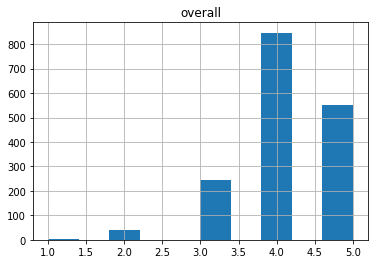

In [35]:
%matplotlib inline
#the distribution of a given variable for each product 
products = df.groupby('asin').mean().round()

def distribution (products,variable):
    products=products[[variable]]
    return(products.hist())

distribution(products,'overall')

We can also isolate a single product by his identification code and study the evolution of its variables of interest.
In the next steps of teh project, this same method could be used not for individual products but for a group of products that we subsample from the category.

In [36]:
#We can isolate a product by his ID:
product = df[df.asin=='B00L86ZKAK'].copy()
product=product.sort_values('reviewTime')
product.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,year,length_review,length_title_reviews
36999,A3KV5PN9P44YG0,B00L86ZKAK,Melanie,"[2, 4]",One of my fav shows,5.0,Five Stars,1404345600,2014-07-03,2014,19,10
36976,AJT9NDFFCC5M9,B00L86ZKAK,gabbygirl,"[2, 3]",Different from most TV and a great escape from...,4.0,Magnetic Magic,1404691200,2014-07-07,2014,125,14
36957,A1X321SRVI41S3,B00L86ZKAK,Angel Mom,"[2, 4]","Love it. The suspense the drama, the cliff han...",5.0,Love it. The suspense the drama,1404691200,2014-07-07,2014,198,31
36959,A17WNTA00WZ65L,B00L86ZKAK,Betsy Bree,"[4, 7]",Even though the first episode was written by S...,2.0,Silly Stuff,1404691200,2014-07-07,2014,649,11
37006,A18HE80910BTZI,B00L86ZKAK,"rbhatta ""A Dinosaur you can trust!""","[1, 2]",Did the producer have tough time keeping the o...,2.0,Why kill old stars?,1404691200,2014-07-07,2014,601,19


In [37]:
#for each product,we define new variables of interest:
#some are stored in a dictionary 
info={'1-id_product':product.asin.unique()[0]}
info['3-rating_average'] = product.overall.mean()
info['2-number_reviewers'] =len(product.reviewerID.unique())
#number of positive reviews
#number of negative reviews
#average sentiment score

info

{'1-id_product': 'B00L86ZKAK',
 '2-number_reviewers': 71,
 '3-rating_average': 3.619718309859155}

In [38]:
#view any variable of interest on a timeline 

def product_timeline (variable):
    p = figure(width=1000, height=500, x_axis_type="datetime")
    avg=product.groupby('reviewTime').mean() # We compute the mean for each date 
    p.line(avg.index.values,avg[variable], color='navy')
    p.title.text = "Product Reviews"
    p.xaxis.axis_label = 'Date'
    show(p)

In [39]:
product_timeline('length_review')

# Conclusion
Our main goal for this milestone was to explore a sample of the dataset in details and write the functions to analyse and visualize it . For this purpose, we chose a dataset that was small enough to run on our computers but unfortunetly it turned out to be too small to give interesting interpretation. 
Indeed, the Amazon Instant Video service is relatively recent and doesn't have enough reviewers to generate relevant insight on its products or consumers. However, conducting this exploratory analysis on a larger dataset should give a better outcome.

Our next step is to extend our analysis to larger categories of products. We will then analyse the trends and seasonality of the time series in details and try to detect recurrent yearly patterns or the influence of external events.


In [ ]:
helpfull / review 

In [ ]:
rating / product characteristics 

# Trying something else :

In [107]:
df2=df[df.asin=='B00LH9ROKM']
df2

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,year,length_review,length_title_reviews
1697513,A14Z0Q1DU6CBJJ,B00LH9ROKM,Chris Kennison,"[1, 2]",Based on the real-life accounts of former New ...,3.0,Se7en meets the Exorcist,1404432000,2014-07-04,2014,2138,24
1697514,A3TYC8T6W81DDB,B00LH9ROKM,C. Sawin,"[1, 2]",Writer and director Scott Derrickson was able ...,4.0,Grotesquely satisfying,1404345600,2014-07-03,2014,2570,22
1697515,A1K3SFTY71SH6Q,B00LH9ROKM,D. Holmes,"[0, 1]",Deliver me from the frustration caused by Deli...,2.0,Serpico meets The Exorcist in this atmospheric...,1404259200,2014-07-02,2014,1820,80
1697516,A2D0ASQY7PAJAG,B00LH9ROKM,"Jacob A. Davis ""Artist, Writer, Theology Nerd""","[0, 0]",Scott Derrickson once again displays his craft...,4.0,A thoughtful film that rises beyond genre trap...,1405728000,2014-07-19,2014,1014,51
1697517,A3F9VH8916IA40,B00LH9ROKM,Jonathan &#34;Jimmy Dean&#34; Lane: libertari...,"[1, 3]",Jump scares are the fart jokes of horror movie...,1.0,Cheap and Lazy,1404604800,2014-07-06,2014,2594,14
1697518,A7DAL9PK7F4M1,B00LH9ROKM,"Paul Donovan ""Paul Donovan""","[4, 5]",Nine Things about the Movie &#8220;Deliver Us ...,1.0,Deliver Us From This Movie,1404518400,2014-07-05,2014,2184,26
1697519,AER15RIMV8E6D,B00LH9ROKM,Pumpkin Man,"[0, 0]","This is the 1st horror film of 2014 I've seen,...",4.0,Creepy & Chilling!!!,1405296000,2014-07-14,2014,645,20
1697520,AYB0IXBPBJ20A,B00LH9ROKM,"Travis Hopson ""shoguntee""","[0, 1]",Just how seriously one should take Scott Derri...,2.0,"Basically an Episode of Criminal Minds, See It...",1404345600,2014-07-03,2014,4252,69
1697521,A1Q3GEO516I4VK,B00LH9ROKM,Twisted Slasher,"[0, 0]","While not nearly as terrifying as say, The Con...",4.0,"Intense and compelling, with a dose of silly o...",1404518400,2014-07-05,2014,1342,56


In [108]:
#function to plot the daily mean of a given variable from 1996-2014 
evolution = df2.groupby('reviewTime').median()
evolution.year=list(map(lambda x:int(x) , evolution.year))
evolution

,overall,unixReviewTime,year,length_review,length_title_reviews
reviewTime,,,,,
2014-07-02,2.0,1.404259e+09,2014,1820.0,80.0
2014-07-03,3.0,1.404346e+09,2014,3411.0,45.5
2014-07-04,3.0,1.404432e+09,2014,2138.0,24.0
2014-07-05,2.5,1.404518e+09,2014,1763.0,41.0
2014-07-06,1.0,1.404605e+09,2014,2594.0,14.0
2014-07-14,4.0,1.405296e+09,2014,645.0,20.0
2014-07-19,4.0,1.405728e+09,2014,1014.0,51.0


In [111]:
def daily_mean (variable):
    # output to static HTML file
    #output_file("Videos_evolution.html", title="Evolution of the number of reviews through the years")
    output_notebook()
    # create a new plot with a a datetime axis type
    p = figure(width=1000, height=500, x_axis_type="datetime")
    # add renderers
    #avg=evolution[variable].rolling(182,center=True).mean() # moving average to have something smoother
    p.circle(evolution.index.values,evolution[variable], color='navy')
    p.line(evolution.index.values,evolution[variable], color='navy')
    #p.line(evolution.index.values,avg, color='red')
    p.title.text = "Daily mean"+str(variable)
    p.legend.location = "top_left"
    p.grid.grid_line_alpha=0
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = str(variable)
    p.xaxis[0].formatter = DatetimeTickFormatter(days='%m/%d',years='%Y',months='%B')
    return p

In [112]:
fig=daily_mean('length_review')
show(fig)

Loading BokehJS ...

In [113]:
#define the function
def variable_year (Y,variable):
    data = evolution[evolution.year==Y]
    data['month']=data.index.month.values
    data=data.groupby('month').median()
    return data[variable]


In [114]:
#evolution.index.month.values
variable_year(2014,'length_review')


month
7    1820.0
Name: length_review, dtype: float64

In [116]:
Years = sorted(evolution.year.unique())
table=pd.DataFrame(index=range(1,13))
variable='length_review'
for y in Years:
    col='year'+str(y)
    table[col]=variable_year(y,variable)
#same comment as above for choosing the year 2008
table
Years

[2014]

In [117]:
#function : takes a list of years and plots the monthly mean for the variable chosen above 
def monthly_mean_Y (Y):
    output_notebook()
    # output to static HTML file
    #output_file("Videos_Number.html", title="Number of reviews")
    if all(x in Years for x in Y):
        p = figure(width=1000, height=500, x_axis_type="datetime")
        colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999']
        k=0
        for y in Y:
            col='year'+str(y)
            p.line(table.index,table[col],color=colors[k], alpha=0.8,legend=str(y))
            k=k+1
        p.title.text = "Number of reviews by day"
        p.legend.location = "top_right"
        p.grid.grid_line_alpha=0
        p.xaxis.axis_label = 'Date'
        p.yaxis.axis_label = 'Number of reviews'
        p.xaxis[0].formatter = DatetimeTickFormatter(days='%m/%d',years='',months='%B')
        return p
    else :
        print('ERROR: Years not in the dataframe')
#show(p)

In [118]:
fig=monthly_mean_Y([2014])
show(fig)

Loading BokehJS ...